In [1]:
import numpy as np
from numpy.typing import NDArray
from matplotlib import pyplot as plt
from scipy import integrate
from typing import Callable

Рассматривается двухточечная краевая задача

$\displaystyle -\frac{d}{dx}\left(p(x)\frac{du}{dx} \right) + q(x)u = f(x)$

$u(a) = 0, \quad u(b) = 0$

In [2]:
N = 10
K = 94

a = np.floor(np.pi*(N+10))
b = a + K/50 + 2
a, b


(np.float64(62.0), np.float64(65.88))

In [15]:
p1 = K*np.exp(10*N/K)
q1 = N*np.sin(np.power(K, N)) + 2*K

def p(x)->float:
    return x**2/50 - 10   #np.sin(N*x/np.pi) + np.cos(2*N)*x - 20

def q(x)->float:
    return 0

def dp(x)->float:
    return 1/25*x #N/np.pi*np.cos(N*x/np.pi) + np.cos(2*N)

# fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# x = np.linspace(a, b, 1000)

# axs[0].plot(x, p(x), label='p(x)', color='fuchsia')
# axs[1].plot(x, q(x), label='q(x)', color='blue')

# axs[0].legend()
# axs[1].legend()
# axs[0].grid()
# axs[1].grid()

#### Составьте нетривиальный физически осмысленный тестовый пример.
$u(x)$ должна быть не отрицательной на отрезке $[a, b]$ и такой, что $u(a)=u(b)=0$

$\displaystyle u = -\cosh{(x-63.94)}+\cosh{(a-63.94)} \implies \frac{du}{dx} = -\sinh{(x-63.94)} \implies \frac{d^2u}{dx^2} = -\cosh{(x-63.94)}$

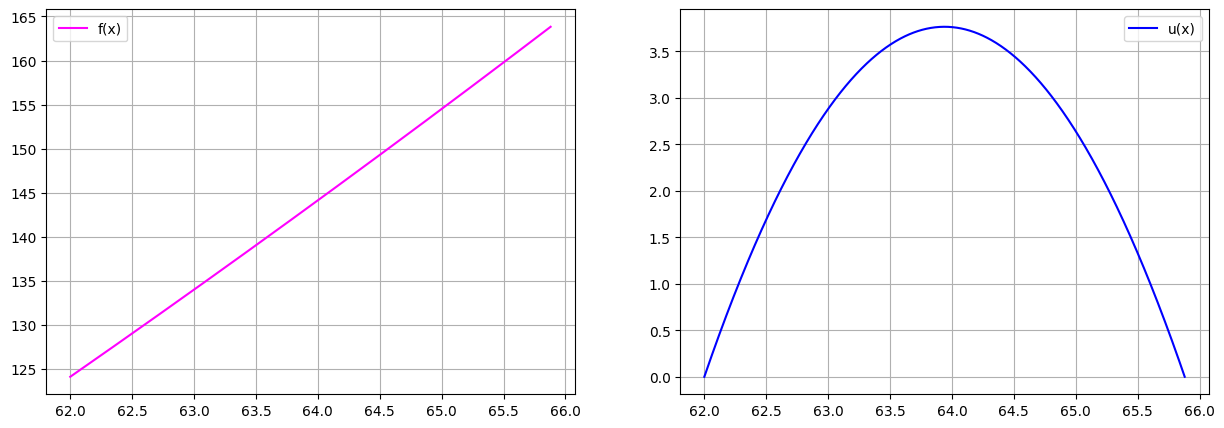

In [14]:
# def u(x)->float:
#     return -np.cosh(x-63.94) + np.cosh(a - 63.94)

# def du(x)->float:
#     return -np.sinh(x-63.94)

# def ddu(x)->float:
#     return -np.cosh(x-63.94)

def u(x)->float:
    return (x-a)*(b-x)

def du(x)->float:
    return b - 2*x + a

def ddu(x)->float:
    return -2

def f(x)->float:
    return -dp(x)*du(x) - p(x)*ddu(x) + q(x)*u(x)

def f2(x)->float:
    return -x/25*(b- 2*x + a) - (x**2/50 - 10)*(-2)

def f1(x)->float:
    return -p1*ddu(x) + q1*u(x)

#flam = lambda x: f(x)

#fxlam = lambda x: x*f(x)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

x = np.linspace(a, b, 1000)

axs[0].plot(x, f2(x), label='f(x)', color='fuchsia')
axs[1].plot(x, u(x), label='u(x)', color='blue')

axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

plt.show()

In [10]:
f(63), f2(63)

(np.float64(134.0224), np.float64(134.0224))

Нули функции $u(x)$

In [89]:
u(a), u(b)

(np.float64(0.0), np.float64(0.0))

#### Напишите функцию, генерирующую матрицу системы МКЭ и вектор правой части в зависимости от шага $h$.

In [38]:
def xi(i:int, h:float)->float:
    n = int((b-a)/h)
    h = (b-a)/n
    return a + i*h
    

def integr(f: Callable[[float], float], x1:float, x2:float)->float:
    return integrate.quad(f, x1, x2)[0]

def simpson(f: Callable[[float], float], x1:float, x2:float, h:float)->float:
    n = int((x2-x1)/h)
    h = (x2-x1)/n
    x = np.linspace(x1, x2, n)

    return 1/3*h*(f(x[0]) + 4*f(x[1:-1][::2]).sum() + 2*f(x[1:-1][1::2]).sum() + f(x[-1]))


    

def fRight(h:float, simp:str='', t:int=1)->NDArray[np.float64]:
    n = int((b-a)/h)
    h = (b-a)/n
    v = np.zeros(n-1)

    if t == 1:
        flam = lambda x: f1(x)
        fxlam = lambda x: x*f1(x)
    else:
        flam = lambda x: f(x)
        fxlam = lambda x: x*f(x)

    if simp == 'simp':
        for i in range(1, n):
            v[i-1] = simpson(fxlam, xi(i-1, h), xi(i, h), h/10) - xi(i-1, h)*simpson(flam, xi(i-1, h), xi(i, h), h/10) + xi(i+1, h)*simpson(flam, xi(i, h), xi(i+1, h), h/10) - simpson(fxlam, xi(i, h), xi(i+1, h), h/10)
    else:
        for i in range(1, n):
            v[i-1] = integr(fxlam, xi(i-1, h), xi(i, h)) - xi(i-1, h)*integr(flam, xi(i-1, h), xi(i, h)) + xi(i+1, h)*integr(flam, xi(i, h), xi(i+1, h)) - integr(fxlam, xi(i, h), xi(i+1, h))
            
    return 1/(h**2)*v

def mtr(h:float, simp:str='', t:int=1)->NDArray[np.float64]:
    n = int((b-a)/h)
    h = (b-a)/n
    print(h)
    
    mtr1 = np.zeros((n-1, n-1))
    mtr2 = np.zeros((n-1, n-1))

    if t == 1:
        np.fill_diagonal(mtr1, 2)
        np.fill_diagonal(mtr1[1:, :], -1)
        np.fill_diagonal(mtr1[:, 1:], -1)

        np.fill_diagonal(mtr2, 4)
        np.fill_diagonal(mtr2[1:, :], 1)
        np.fill_diagonal(mtr2[:, 1:], 1)

        res = p1/(h**2)*mtr1 + q1/6*mtr2
    else:
        plam = lambda x: p(x)
        qlam = lambda x: q(x)
        qxlam = lambda x: x*q(x)
        qx2lam = lambda x: np.power(x, 2)*q(x)

        if simp == 'simp':
            #первая матрица
            #главная диагональ
            diag = np.zeros(n-1)
            for k in range(1, n):
                diag[k-1] = simpson(plam, xi(k-1, h), xi(k+1, h), h/10)
            np.fill_diagonal(mtr1, diag)
            #первая наддиагональ
            diag = np.zeros(n-2)
            for k in range(1, n-1):
                diag[k-1] = -simpson(plam, xi(k, h), xi(k+1, h), h/10)
            np.fill_diagonal(mtr1[:, 1:], diag)
            #первая поддиагональ
            diag = np.zeros(n-2)
            for k in range(1, n-1):
                diag[k-1] = -simpson(plam, xi(k-1, h), xi(k, h), h/10)
            np.fill_diagonal(mtr1[1:, :], diag)

            #вторая матрица
            #главная диагональ
            diag = np.zeros(n-1)
            for k in range(1, n):
                diag[k-1] = simpson(qx2lam, xi(k-1, h), xi(k, h), h/10) - 2*xi(k-1, h)*simpson(qxlam, xi(k-1, h), xi(k, h), h/10) + np.power(xi(k-1, h), 2)*simpson(qlam, xi(k-1, h), xi(k, h), h/10) + np.power(xi(k+1, h), 2)*simpson(qlam, xi(k, h), xi(k+1, h), h/10) - 2*xi(k+1, h)*simpson(qxlam, xi(k, h), xi(k+1, h), h/10) + simpson(qx2lam, xi(k, h), xi(k+1, h), h/10)
            np.fill_diagonal(mtr2, diag)
            #первая наддиагональ
            diag = np.zeros(n-2)
            for k in range(1, n-1):
                diag[k-1] = xi(k+1, h)*simpson(qxlam, xi(k, h), xi(k+1, h), h/10) - xi(k, h)*xi(k+1, h)*simpson(qlam, xi(k, h), xi(k+1, h), h/10) - simpson(qx2lam, xi(k, h), xi(k+1, h), h/10) + xi(k, h)*simpson(qxlam, xi(k, h), xi(k+1, h), h/10)
            np.fill_diagonal(mtr2[:, 1:], diag)
            #первая поддиагональ
            diag = np.zeros(n-2)
            for k in range(1, n-1):
                diag[k-1] = xi(k, h)*simpson(qxlam, xi(k-1, h), xi(k, h), h/10) - xi(k, h)*xi(k-1, h)*simpson(qlam, xi(k-1, h), xi(k, h), h/10) - simpson(qx2lam, xi(k-1, h), xi(k, h), h/10) + xi(k-1, h)*simpson(qxlam, xi(k-1, h), xi(k, h), h/10)
            np.fill_diagonal(mtr2[1:, :], diag)
        else:
            #первая матрица
            #главная диагональ
            diag = np.zeros(n-1)
            for k in range(1, n):
                diag[k-1] = integr(plam, xi(k-1, h), xi(k+1, h))
            np.fill_diagonal(mtr1, diag)
            #первая наддиагональ
            diag = np.zeros(n-2)
            for k in range(1, n-1):
                diag[k-1] = integr(plam, xi(k, h), xi(k+1, h))
            np.fill_diagonal(mtr1[:, 1:], -diag)
            #первая поддиагональ
            diag = np.zeros(n-2)
            for k in range(1, n-1):
                diag[k-1] = integr(plam, xi(k-1, h), xi(k, h))
            np.fill_diagonal(mtr1[1:, :], -diag)
            print(mtr1)

            #вторая матрица
            #главная диагональ
            diag = np.zeros(n-1)
            for k in range(1, n):
                diag[k-1] = integr(qx2lam, xi(k-1, h), xi(k, h)) - 2*xi(k-1, h)*integr(qxlam, xi(k-1, h), xi(k, h)) + np.power(xi(k-1, h), 2)*integr(qlam, xi(k-1, h), xi(k, h)) + np.power(xi(k+1, h), 2)*integr(qlam, xi(k, h), xi(k+1, h)) - 2*xi(k+1, h)*integr(qxlam, xi(k, h), xi(k+1, h)) + integr(qx2lam, xi(k, h), xi(k+1, h))
            np.fill_diagonal(mtr2, diag)
            #первая наддиагональ
            diag = np.zeros(n-2)
            for k in range(1, n-1):
                diag[k-1] = xi(k+1, h)*integr(qxlam, xi(k, h), xi(k+1, h)) - xi(k, h)*xi(k+1, h)*integr(qlam, xi(k, h), xi(k+1, h)) - integr(qx2lam, xi(k, h), xi(k+1, h)) + xi(k, h)*integr(qxlam, xi(k, h), xi(k+1, h))
            np.fill_diagonal(mtr2[:, 1:], diag)
            #первая поддиагональ
            diag = np.zeros(n-2)
            for k in range(1, n-1):
                diag[k-1] = xi(k, h)*integr(qxlam, xi(k-1, h), xi(k, h)) - xi(k, h)*xi(k-1, h)*integr(qlam, xi(k-1, h), xi(k, h)) - integr(qx2lam, xi(k-1, h), xi(k, h))+ xi(k-1, h)*integr(qxlam, xi(k-1, h), xi(k, h))
            np.fill_diagonal(mtr2[1:, :], diag)
            #print(mtr2)

        res = 1/(h**3)*(mtr1 + mtr2)

    return res

#### Проверьте работоспособность метода.

0.00500645161290322
[[ 0.66978729 -0.33492473  0.         ...  0.          0.
   0.        ]
 [-0.33486256  0.66991163 -0.3349869  ...  0.          0.
   0.        ]
 [ 0.         -0.33492473  0.67003598 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.76862964 -0.38434784
   0.        ]
 [ 0.          0.          0.         ... -0.3842818   0.76876171
  -0.38441388]
 [ 0.          0.          0.         ...  0.         -0.38434784
   0.7688938 ]]
[0.00311268 0.00311391 0.00311513 0.00311636 0.00311758 0.00311881
 0.00312004 0.00312126 0.00312249 0.00312371 0.00312494 0.00312617
 0.0031274  0.00312862 0.00312985 0.00313108 0.00313231 0.00313353
 0.00313476 0.00313599 0.00313722 0.00313845 0.00313968 0.00314091
 0.00314213 0.00314336 0.00314459 0.00314582 0.00314705 0.00314828
 0.00314951 0.00315074 0.00315197 0.0031532  0.00315443 0.00315566
 0.00315689 0.00315813 0.00315936 0.00316059 0.00316182 0.00316305
 0.00316428 0.00316551 0.00316675 0.0031679

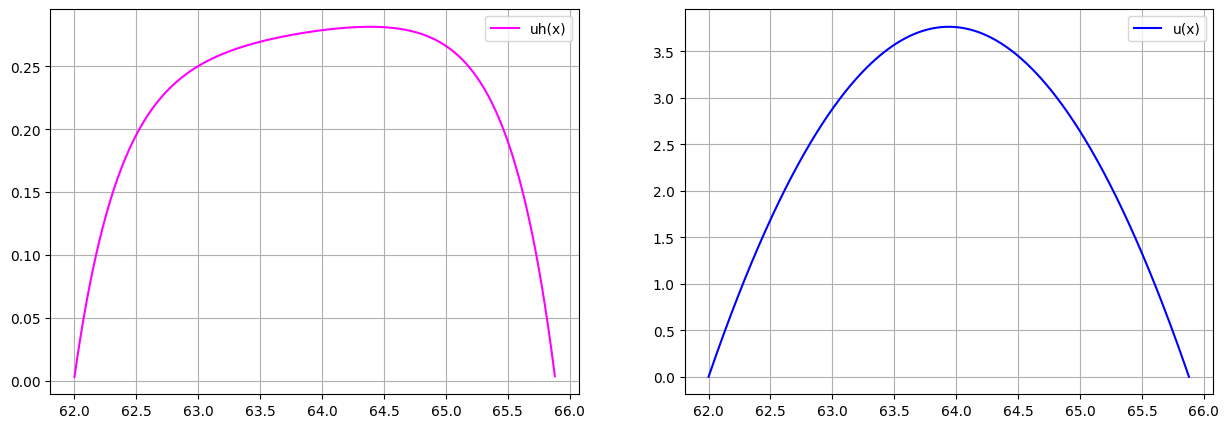

In [39]:
h = 0.005

alpha = np.linalg.solve(mtr(h, 'no', 2), fRight(h, 'no', 2))

x = np.linspace(a, b, int((b-a)/h)-1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(x, alpha, color='fuchsia', label='uh(x)')
axs[1].plot(x, u(x), color='blue', label='u(x)')

for i in range(axs.size):
    axs[i].grid()
    axs[i].legend()

print(f'Норма погрешности: {np.sqrt(h)*np.linalg.norm(u(x)-alpha, 2)}')

#### Решите систему методом сопряжённых градиентов с точностью $10^{-10}$ для шага $h = 10^{-1}, 20^{-1}, 30^{-1}, . . . , 1000^{-1}$.

##### Алгоритм CG

Начальные данные\
$\qquad x^0$\
$\qquad r^0 = b - Ax^0$\
$\qquad z^0 = r^0$\
$i$-ая итерация\
$\qquad w^{i} = Az^{i-1}$\
$\qquad q_{i} = (r^{i-1}, r^{i-1})$\
$\qquad \displaystyle a_i = \frac{q_{i}}{(w^{i}, z^{i-1})}$\
$\qquad x^i = x^{i-1} + a_iz^{i-1}$\
$\qquad r^i = r^{i-1} - a_iw^{i}$\
$\qquad \displaystyle \beta_i = \frac{(r^{i}, r^{i})}{q_{i}}$\
$\qquad z^i = r^i + \beta_iz^{i-1}$\
Критерий остановки\
$\qquad ||r^i||_2 < error$


In [25]:
hArr = np.arange(10, 1010, 10)
hArr = 1/hArr
nArr = np.zeros(hArr.size)
for i in range(nArr.size):
  nArr[i] = int((b-a)/hArr[i])-1

def CG(A:NDArray[np.float64], b:NDArray[np.float64])->NDArray[np.float64]:
  x = np.zeros(b.size)
  r = b - np.dot(A, x)
  z = np.copy(r)
  eps = 10**(-10)

  while True:
    w = np.dot(A, z)
    rsq = np.dot(r, r)
    a = rsq/np.dot(w, z)
    x = x + a*z
    r1 = r - a*w
    beta = np.dot(r1, r1)/rsq
    z = r1 + beta*z
    r = r1
    if np.linalg.norm(r, 2) < eps:
      break

  return x

nArr[9], hArr[9]

(np.float64(386.0), np.float64(0.01))

In [80]:
alpha = []

for i in range(hArr.size):
  alpha.append(CG(mtr(hArr[i]), fRight(hArr[i])))

#### Постройте график погрешности $r(h) = \sqrt{h} ||u-u^h||_2$ в логарифмической шкале

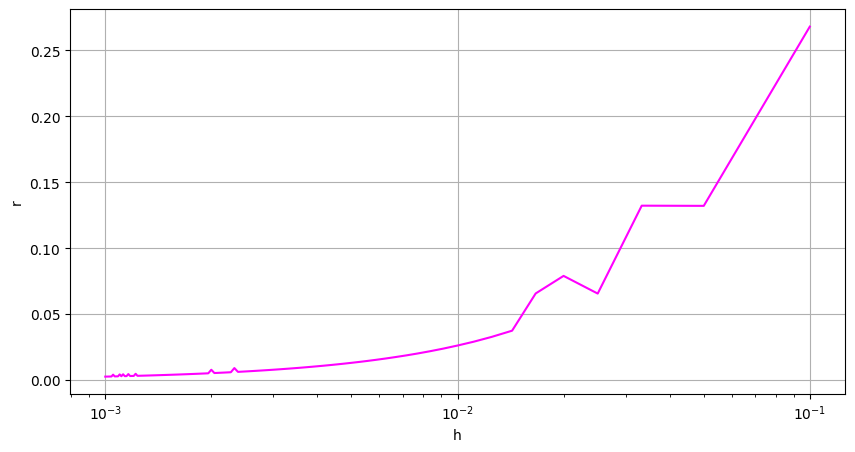

In [81]:
hSqrt = np.sqrt(hArr)
x = []
for i in nArr.astype(int):
    x.append(np.linspace(a, b, i))
r = []
for i in range(hArr.size):
    r.append(hSqrt[i]*np.linalg.norm(u(x[i]) - alpha[i], 2))

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(hArr, r, color='fuchsia')
plt.xscale('log')
plt.xlabel('h')
plt.ylabel('r')
plt.grid()


#### Откуда взялся множитель $\sqrt{h}$ в формуле из пункта 6?

#### Установите эксперементально порядок сходимости метода по $h$.

In [82]:
for i in range(2):
    print(f'Шаг метода: {hArr[i]}, погрешность метода: {r[i]}')

Шаг метода: 0.1, погрешность метода: 0.2679083320336718
Шаг метода: 0.05, погрешность метода: 0.13205182942158897


Видим, что при уменьшении шага в два раза погрешность уменьшилась в $\displaystyle \frac{0.268}{0.132} \approx 2$ раза $\implies$ первый порядок сходимости по $h$

#### Формула Симпсона для интегрирования

In [83]:
alphaSimp = []

for i in range(hArr.size):
  alphaSimp.append(CG(mtr(hArr[i]), fRight(hArr[i], 'simp')))

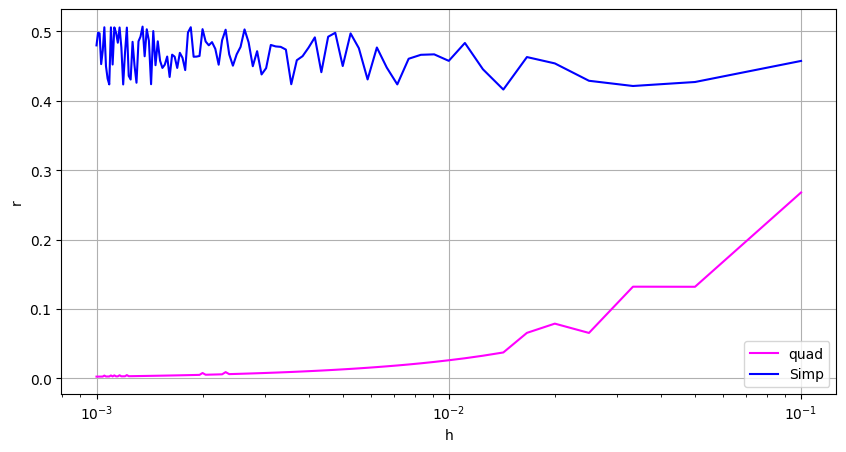

In [84]:
rSimp = []
for i in range(hArr.size):
    rSimp.append(hSqrt[i]*np.linalg.norm(u(x[i]) - alphaSimp[i], 2))

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(hArr, r, color='fuchsia', label='quad')
axs.plot(hArr, rSimp, color='blue', label='Simp')
plt.legend()
plt.xscale('log')
plt.xlabel('h')
plt.ylabel('r')
plt.grid()